# Attention Weight Analysis for AnySleep

This notebook visualizes the learned attention weights from the AnySleep model
to understand which channels the model prioritizes at different network depths.

## Purpose

Analyze what the channel attention mechanism learns by examining:
- How attention weights vary across channel types (EOG vs different EEG regions)
- How attention patterns change at different depths in the U-Net architecture
- Whether attention patterns are consistent across independent training runs

## Method

1. **Load attention weights** from evaluation runs with `save_att_weights=True`
   - Weights saved per layer (depth) and per channel combination

2. **Group channels** into anatomical categories:
   - **EOG**: E1-M2, EOG1, EOG(L) → left EOG
   - **Frontal**: F3-M2, F3-CLE, F3-LER → EEG F3
   - **Central**: C3-M2, C3-CLE, C3-LER → EEG C3
   - **Occipital**: O1-M2, O1-CLE, O1-LER → EEG O1

3. **Compute average attention** per channel type per layer
   - Average across all recordings and channel combinations

4. **Visualize as heatmap** (channels × layers)
   - Shows attention distribution across U-Net depth
   - Includes column for overall average

## Interpretation

- Higher values indicate the model assigns more importance to that channel at that depth
- Attention weights are normalized (softmax) so they sum to 1 across channels
- Consistent patterns across training runs suggest learned preferences are robust

## Output

- `analyze_attention_weights_all.svg`: Heatmaps for all 3 training runs

## Data Requirements

- Attention weight files (`attention_weights.npz`, `channel_names.npy`)
- Generated by running evaluation with `model.save_att_weights=True`

In [1]:
import numpy as np

run_folders_dict = {
    "run_0": ["../../logs/exp002/exp002a/sweep-2025-10-14_11-33-51_attention-weights/0",
              "../../logs/exp002/exp002a/sweep-2025-10-14_11-38-43_attention-weights/0",
              "../../logs/exp002/exp002a/sweep-2025-10-14_11-39-46_attention-weights/0",
              "../../logs/exp002/exp002a/sweep-2025-10-14_11-40-44_attention-weights/0"],
    "run_1": ["../../logs/exp002/exp002a/sweep-2025-10-14_11-33-51_attention-weights/1",
              "../../logs/exp002/exp002a/sweep-2025-10-14_11-38-43_attention-weights/1",
              "../../logs/exp002/exp002a/sweep-2025-10-14_11-39-46_attention-weights/1",
              "../../logs/exp002/exp002a/sweep-2025-10-14_11-40-44_attention-weights/1"],
    "run_2": ["../../logs/exp002/exp002a/sweep-2025-10-14_11-33-51_attention-weights/2",
              "../../logs/exp002/exp002a/sweep-2025-10-14_11-38-43_attention-weights/2",
              "../../logs/exp002/exp002a/sweep-2025-10-14_11-39-46_attention-weights/2",
              "../../logs/exp002/exp002a/sweep-2025-10-14_11-40-44_attention-weights/2"],
}


def get_attention_weights(run_folders):
    fname_attention_weights = "attention_weights.npz"
    fname_channel_names = "channel_names.npy"

    attention_weights = {}
    channel_names = []
    for folder in run_folders:
        f_att_w = np.load(f"{folder}/{fname_attention_weights}")
        f_ch_n = np.load(f"{folder}/{fname_channel_names}")
        for k in f_att_w.files:
            if k not in attention_weights:
                attention_weights[k] = []
            attention_weights[k].append(f_att_w[k])
        channel_names.append(f_ch_n)

    attention_weights = {l: np.concatenate(att_w, axis=0)
                         for l, att_w in attention_weights.items()}
    channel_names = np.concatenate(channel_names, axis=0)

    mapped_att_weights = {}
    for layer in attention_weights:
        mapped_att_weights[layer] = {}
        for ch_comb, att_w in zip(channel_names, attention_weights[layer]):
            channels = ch_comb.split("&")
            for ch_i, ch in enumerate(channels):
                if ch not in mapped_att_weights[layer]:
                    mapped_att_weights[layer][ch] = []
                mapped_att_weights[layer][ch].append(att_w[ch_i])

    new_mapped_att_weights = {}
    for layer in mapped_att_weights:
        new_mapped_att_weights[layer] = {}
        new_mapped_att_weights[layer]["EOG"] = mapped_att_weights[layer]["E1-M2"] + mapped_att_weights[layer]["EOG1"] + \
                                               mapped_att_weights[layer]["EOG(L)"]
        new_mapped_att_weights[layer]["frontal"] = mapped_att_weights[layer]["F3-M2"] + mapped_att_weights[layer][
            "F3-CLE"] + mapped_att_weights[layer]["F3-LER"]
        new_mapped_att_weights[layer]["central"] = mapped_att_weights[layer]["C3-M2"] + mapped_att_weights[layer][
            "C3-CLE"] + mapped_att_weights[layer]["C3-LER"]
        new_mapped_att_weights[layer]["occipital"] = mapped_att_weights[layer]["O1-M2"] + mapped_att_weights[layer][
            "O1-CLE"] + mapped_att_weights[layer]["O1-LER"]

    return new_mapped_att_weights

In [2]:
import matplotlib.pyplot as plt


def plot_matrix(matrix, fmt, xlabels, ylabels, fig, axis):
    axis.imshow(matrix, interpolation='nearest', cmap='Blues')
    axis.set_xticks(np.arange(matrix.shape[1]), xlabels)
    axis.set_yticks(np.arange(matrix.shape[0]), ylabels)
    axis.set_ylim(matrix.shape[0] - 0.5, -0.5)

    # loop over data dimensions and create text annotations.
    thresh = matrix.min() + (matrix.max() - matrix.min()) / 2.
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            axis.text(j, i, format(matrix[i, j], fmt)[1:], ha='center', va='center',
                      color='white' if matrix[i, j] > thresh else 'black')

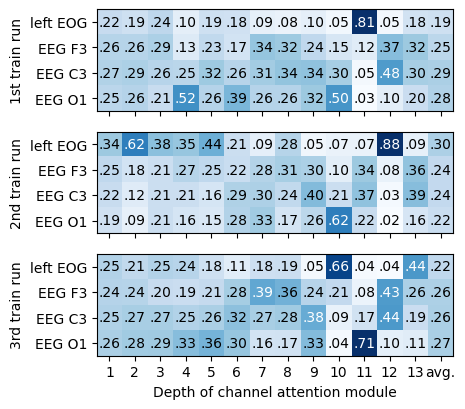

In [3]:
channels = ["EOG", "frontal", "central", "occipital"]
channel_labels = ["left EOG", "EEG F3", "EEG C3", "EEG O1"]

fig, axes = plt.subplots(len(run_folders_dict), 1, figsize=(10, 4.5), sharex=True, sharey=True)
for i, (run_name, run_folders) in enumerate(run_folders_dict.items()):
    new_mapped_att_weights = get_attention_weights(run_folders)
    matrix = np.array([[np.mean(new_mapped_att_weights[l][c])
                        for c in channels]
                       for l in new_mapped_att_weights]).T

    matrix = np.column_stack((matrix, matrix.mean(1)))

    layer_labels = [i + 1 for i in range(len(new_mapped_att_weights))] + ["avg."]
    plot_matrix(matrix, ".2f", layer_labels, channel_labels, fig, axes[i])
    plt.xlabel("Depth of channel attention module")

axes[0].set_ylabel("1st train run")
axes[1].set_ylabel("2nd train run")
axes[2].set_ylabel("3rd train run")

plt.savefig("analyze_attention_weights_all.svg")
plt.show()